In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

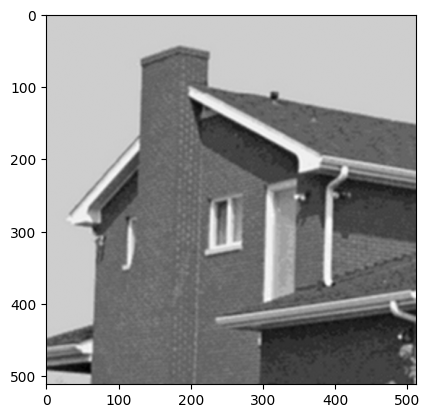

In [2]:
img = cv2.imread('TEST_IMAGES/house.tif', 0)  # Load as grayscale
plt.imshow(img, cmap='gray')
plt.show()

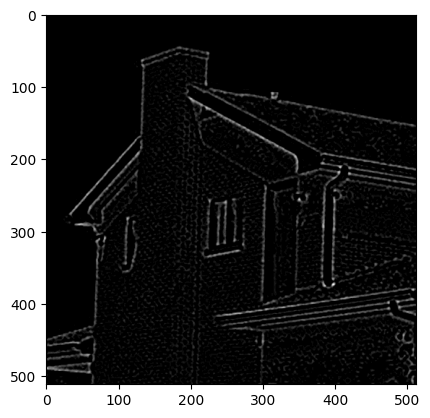

In [3]:
def generateKernel(k_size, sigma):
    ax = np.arange(-(k_size//2), k_size//2)
    x, y = np.meshgrid(ax, ax)

    normalization = -(1/(np.pi * sigma**4))/(np.pow(sigma,4))
    gaussian = (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

    kernel = normalization*gaussian
    return kernel/np.sum(np.abs(kernel))



def edgeDetector(image, k_size, sigma):
    kernel = generateKernel(k_size, sigma)
    img_fltrd = cv2.filter2D(image, -1, kernel)
    
    return img_fltrd

k_size = 9
sigma = 1

out_img = edgeDetector(img, k_size, sigma)

img_fltrd_scaled = cv2.convertScaleAbs(out_img)
plt.imshow(img_fltrd_scaled, cmap="gray")
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 [5 3 0 ... 0 0 0]]


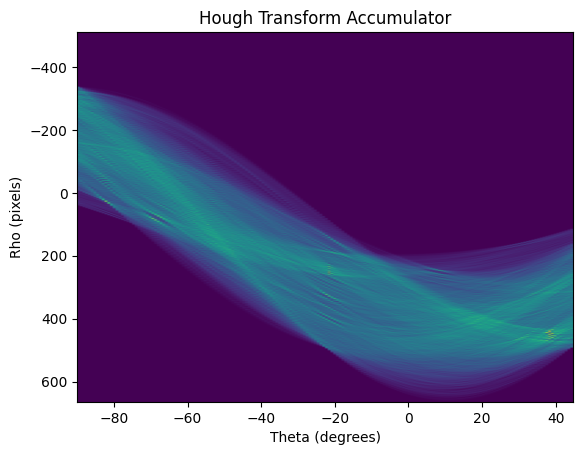

In [4]:
def houghTransform(image, num_thetas=180, threshold=100):
    h, w = image.shape

    max_dist = int(np.ceil(np.sqrt(h**2 + w**2)))
    rho_ls = np.linspace(-max_dist, max_dist, 2 * max_dist)
    theta_ls = np.deg2rad(np.linspace(-90, 90, num_thetas))

    cos_theta = np.cos(theta_ls)
    sin_theta = np.sin(theta_ls)
    acc = np.zeros((2 * max_dist, num_thetas), dtype=int)

    edge_y_indices, edge_x_indices = np.nonzero(image)

    for i in range(len(edge_x_indices)):
        x = edge_x_indices[i]
        y = edge_y_indices[i]
        for theta_idx in range(num_thetas):
            # rho = x*cos(theta) + y*sin(theta)
            rho = int(round(x * cos_theta[theta_idx] + y * sin_theta[theta_idx])) + max_dist
            acc[rho, theta_idx] += 1

    # Identify peaks 
    peak_indices = np.argwhere(acc > threshold)

    rho_ls = rho_ls[peak_indices[:, 0]]
    theta_ls = theta_ls[peak_indices[:, 1]]

    return rho_ls, theta_ls, acc, theta_ls, rho_ls

def houghLines(img):
    thetas = np.deg2rad(np.arange(-90.0, 90.0))

    w, h = img.shape
    diag_len = int(np.ceil(np.sqrt(w * w + h * h)))

    rhos = np.linspace(int(-diag_len), int(diag_len), int(diag_len * 2.0))

    accumulator, thetas, rhos = houghTransform(img)

    return accumulator, thetas, rhos


# Perform the Hough Transform
print(out_img)
rho_values, theta_values, accumulator, _, _ = houghTransform(out_img, threshold=50)

plt.imshow(accumulator, aspect='auto', extent=[np.rad2deg(theta_values[0]), np.rad2deg(theta_values[-1]), rho_values[-1], rho_values[0]])
plt.title('Hough Transform Accumulator')
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho (pixels)')
plt.show()

Number of lines detected: 85


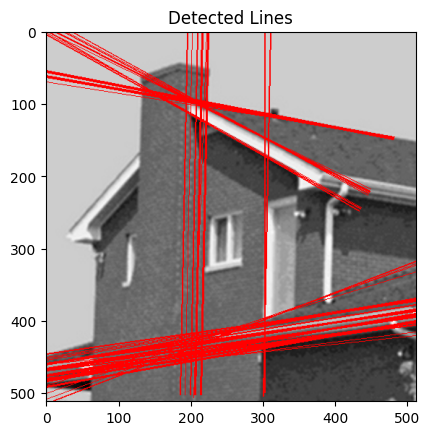

In [5]:
# Constants for line detection
acc_threshold = 250
ext_factor = 500

image_diagonal = int(np.ceil(np.sqrt(img.shape[0]**2 + img.shape[1]**2)))
theta_degrees = np.arange(-90.0, 90.0)
theta_radians = np.deg2rad(theta_degrees) 

rho_range = np.linspace(-image_diagonal, image_diagonal, 2 * image_diagonal)

high_acc_indices = np.where(accumulator > acc_threshold)
rho_fltr = rho_range[high_acc_indices[0]]
theta_fltr = theta_radians[high_acc_indices[1]]
line_params = np.vstack([rho_fltr, theta_fltr]).T

print("Number of lines detected:", line_params.shape[0])

color_image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

def cartesianConversion(rho, theta):
    cosine_theta = np.cos(theta)
    sine_theta = np.sin(theta)
    x0 = cosine_theta * rho
    y0 = sine_theta * rho
    x1 = int(x0 + ext_factor * (-sine_theta))
    y1 = int(y0 + ext_factor * (cosine_theta))
    x2 = int(x0 - ext_factor * (-sine_theta))
    y2 = int(y0 - ext_factor * (cosine_theta))
    return (x1, y1), (x2, y2)

for rho, theta in line_params:
    line_start, line_end = cartesianConversion(rho, theta)
    cv2.line(color_image, line_start, line_end, (0, 0, 255), 1)

plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines')
plt.show()

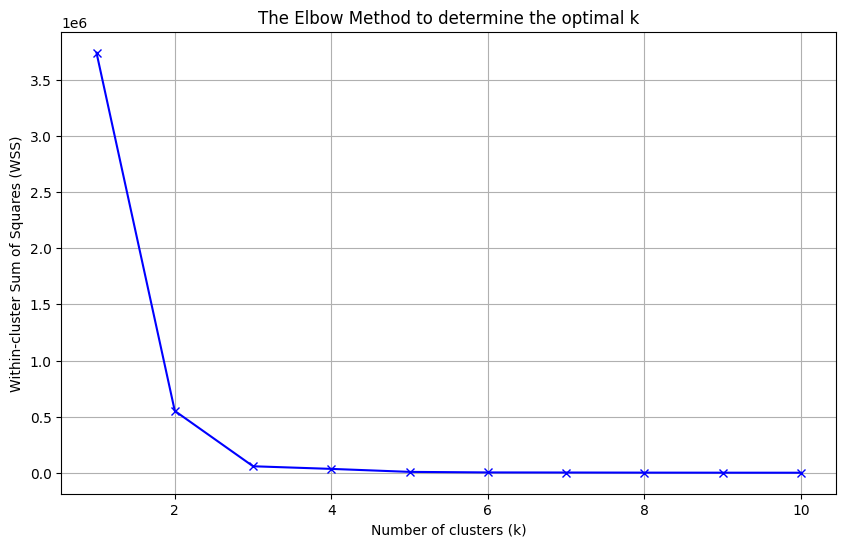

In [6]:
from sklearn.cluster import KMeans

def calculateWSS(points, k_max):
    wss = []
    k_range = range(1, k_max + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(points)
        wss.append(kmeans.inertia_)  # inertia_ is the WSS
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wss, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster Sum of Squares (WSS)')
    plt.title('The Elbow Method to determine the optimal k')
    plt.grid(True)
    plt.show()

calculateWSS(line_params, 10)

In [65]:
import random

def generateRandomPoints(line_start, line_end, num_samples=100):
    """ Generate random points along the line between two given points. """
    t_values = np.random.uniform(low=0, high=1, size=num_samples)
    points = line_start + np.outer(t_values, (line_end - line_start))
    return points.reshape(-1, 2)

def calcDistance(slope, intercept, point):
    """ Calculate perpendicular distance of a point from a line given by slope and intercept. """
    return abs(slope * point[0] - point[1] + intercept) / np.sqrt(slope**2 + 1)

def calcSlopeIntercept(point1, point2):
    """ Calculate slope and intercept from two points. """
    x1, y1 = point1
    x2, y2 = point2
    if x2 != x1:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
    else:
        slope = np.inf  
        intercept = x1  
    return slope, intercept

def RANSAC(data, num_iterations=50, threshold=1.0):
    """ RANSAC algorithm to find the best fitting line model in the data. """
    best_slope = best_intercept = None
    max_inliers = []

    for _ in range(num_iterations):
        data_list = list(map(tuple, data))  
        sample_points = random.sample(data_list, 2)
        slope, intercept = calcSlopeIntercept(sample_points[0], sample_points[1])
        inliers = []

        for point in data_list:
            if calcDistance(slope, intercept, point) < threshold:
                inliers.append(point)

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_slope = slope
            best_intercept = intercept

    return best_slope, best_intercept, max_inliers

cluster_labels = np.array([1, 2, 3])  # Cluster labels

In [66]:
# Dict to stor sampled points
clustered_line_samples = {}

for cluster_id in np.unique(cluster_labels):
    sampled_points = []
    
    for index, cluster in enumerate(cluster_labels):
        if cluster == cluster_id:
            rho, theta = rho_fltr[index], theta_fltr[index]
            line_start, line_end = cartesianConversion(rho, theta)
            
            # Convert to numpy array
            line_start = np.array(line_start)
            line_end = np.array(line_end)

            random_factors = np.random.uniform(low=0, high=1, size=2)
            sampled_points_along_line = line_start + np.outer(random_factors, (line_end - line_start))
            
            sampled_points.extend(sampled_points_along_line)
    
    clustered_line_samples[cluster_id] = np.vstack(sampled_points)

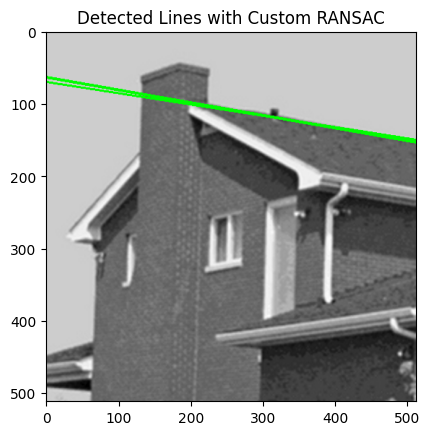

In [68]:

# Dictionary to store random points along detected lines for each cluster
clustered_points = {}
for cluster_index in np.unique(cluster_labels):
    sampled_points = []
    for index in np.where(cluster_labels == cluster_index)[0]:
        rho, theta = line_params[index]
        line_start, line_end = cartesianConversion(rho, theta)
        sampled_points.extend(generateRandomPoints(np.array(line_start), np.array(line_end)))
    clustered_points[cluster_index] = np.array(sampled_points)

# Run custom RANSAC on each cluster's points
fitted_lines = {}
for cluster_index, points in clustered_points.items():
    slope, intercept, inliers = RANSAC(points)
    fitted_lines[cluster_index] = {'slope': slope, 'intercept': intercept, 'inliers': inliers}
    # print(f"Cluster {cluster_index}: Number of inliers: {len(inliers)}")

# Draw lines on the original image
image_with_lines = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
for cluster_index, line_data in fitted_lines.items():
    if line_data['slope'] != np.inf:
        # Normal line case
        x_vals = np.array([0, image_with_lines.shape[1]])
        y_vals = line_data['slope'] * x_vals + line_data['intercept']
    else:
        # Vertical line case
        x_vals = np.array([line_data['intercept'], line_data['intercept']])
        y_vals = np.array([0, image_with_lines.shape[0]])

    pt1 = (int(x_vals[0]), int(y_vals[0]))
    pt2 = (int(x_vals[1]), int(y_vals[1]))
    cv2.line(image_with_lines, pt1, pt2, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines with Custom RANSAC')
plt.show()